В этом ноутбуке были протестированы три метода генерации эмбеддингов (PCA, non-negative ALS, autoencoder) для генерации профилей пользователей из датасета Amazon меньшей размерности. Напомним, что исходная размерность профиля равно 303. Кроме того, применимость методов генерации эмбеддингов была исследована с точки зрения качества моделей генерации синтетических данных и с точки зрения качества компоненты функции отклика, отвечающей за приближение отклика из исторических данных.

In [1]:
import os

import pandas as pd
import numpy as np
import time
import matplotlib
import itertools

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
import pyspark.sql.types as st
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline 
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window

from replay.session_handler import State

from simulator.utils import pandas_to_spark
from simulator.response import ParametricResponseFunction, BernoulliResponse
from simulator.utils import VectorElementExtractor
from simulator.modules import RealDataGenerator, SDVDataGenerator
from simulator.modules import evaluate_synthetic
from simulator.modules import EncoderEstimator

from sklearn.metrics import roc_auc_score, precision_score, recall_score

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

SPARK_LOCAL_DIR = './tmp'

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

/data/home/estavinova/.conda/envs/sim-exp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/11/17 13:51:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/17 13:51:32 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/17 13:51:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/17 13:51:33 WARN Utils: Service 'SparkUI' could not bind on port 4041.

# Read data

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Amazon): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [2]:
DATA_PATH = r'file:///mnt/dgxhome/home/estavinova/simulator/Amazon/home'

In [3]:
USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_GENERATOR_FRAC = 0.0033 # 10k users

users_df_train = spark.read.parquet(f'{DATA_PATH}/train/users.parquet')
items_df_train = spark.read.parquet(f'{DATA_PATH}/train/items.parquet')
log_df_train   = spark.read.parquet(f'{DATA_PATH}/train/rating.parquet')

log_df_train = log_df_train.join(users_df_train, log_df_train['user_idx'] == users_df_train['user_idx'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_idx'] == items_df_train['item_idx'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)
    
ITEMS_FEATURES = items_df_train.columns[1:3] + items_df_train.columns[4:]

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.sample(0.6818).cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/17 13:52:58 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


9998142

In [4]:
users_df_val = spark.read.parquet(f'{DATA_PATH}/val/users.parquet')
items_df_val = spark.read.parquet(f'{DATA_PATH}/val/items.parquet')
log_df_val   = spark.read.parquet(f'{DATA_PATH}/val/rating.parquet')

log_df_val = log_df_val.join(users_df_val, log_df_val['user_idx'] == users_df_val['user_idx'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_idx'] == items_df_val['item_idx'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.sample(0.6778).cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000169

In [5]:
users_df_test = spark.read.parquet(f'{DATA_PATH}/test/users.parquet')
items_df_test = spark.read.parquet(f'{DATA_PATH}/test/items.parquet')
log_df_test   = spark.read.parquet(f'{DATA_PATH}/test/rating.parquet')

log_df_test = log_df_test.join(users_df_test, log_df_test['user_idx'] == users_df_test['user_idx'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_idx'] == items_df_test['item_idx'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.sample(0.6758).cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5000212

# Initial quality of response function Real component

Сначала оценим качество компоненты Real, отвечающей за приближение отклика в исторических данных, на исходных профилях польззователей и предложений.

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

# Logistic regression

In [6]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:3] + users_df_train.columns[4:] + ITEMS_FEATURES,
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(users_df_train, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

22/11/07 01:03:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/07 01:03:14 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Fitting of logistic regression: 
358.73981070518494


In [7]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [8]:
test_df = log_df_test.join(users_df_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [9]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.00354766845703125


In [10]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.7094342331809629


# Random forest

In [11]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
549.5236835479736


In [12]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [13]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0005574226379394531


In [14]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.5739361266676747


# PCA

In [8]:
va = VectorAssembler(
    inputCols=users_df_train.columns[1:3] + users_df_train.columns[4:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
start = time.time()
model = pca.fit(va.transform(users_df_train))
end = time.time()
print("PCA fitting: ")
print(end - start)
model.explainedVariance

22/11/17 14:00:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/17 14:00:22 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/17 14:00:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/17 14:00:52 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


PCA fitting: 
52.55409598350525


DenseVector([0.7563, 0.0684, 0.0162, 0.0123, 0.0097, 0.0068, 0.006, 0.0046, 0.0044])

In [10]:
pca_users = model.transform(va.transform(users_df_train)).select(['user_idx', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_idx'] + [col('user_feature')[i] for i in range(9)])
pca_users.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,4024009,-5.011489,-0.208618,-0.518342,0.096146,0.128758,-0.025352,0.231048,0.015152,0.018341
1,1756928,-5.004752,-0.189431,-0.341130,-0.019720,0.301034,-0.102309,0.114777,-0.027779,0.058556
2,1459280,-5.030922,0.814557,-0.393165,-0.024644,0.365638,0.049733,0.094488,-0.010670,0.119320
3,5276428,-4.012828,0.859328,0.006674,-0.330849,0.199110,-0.067980,0.098179,-0.008086,0.111363
4,1716148,-5.020726,0.837062,-0.136077,-0.136654,0.430284,-0.229096,0.133218,-0.054900,0.165446
...,...,...,...,...,...,...,...,...,...,...
3053588,265805,-5.033073,0.826746,-0.016870,0.269960,0.265318,-0.253668,0.546574,-0.013333,-0.052161
3053589,2933675,-5.011009,-0.165077,-0.057404,0.071152,0.252052,-0.182114,0.347975,-0.108967,-0.261822
3053590,4264698,-4.008367,-0.132868,0.022372,0.211736,0.121479,-0.165102,0.411344,-0.224446,-0.163983
3053591,811746,-4.754839,0.084321,-0.142392,-0.019201,0.217673,-0.178274,0.336264,0.008475,0.124137


In [11]:
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_idx', 'pca_features'])

pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_idx'] + [col('user_feature')[i] for i in range(9)])
pca_users_val.toPandas()

,user_idx,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,3835593,-4.018266,0.575734,-0.199374,0.083997,0.243594,-0.166446,0.217244,0.062339,0.162609
1,5139399,-4.233633,0.737578,0.019695,0.107156,0.061601,-0.137092,0.155856,0.027708,0.152988
2,5140169,-5.000499,-0.147954,-0.137309,-0.178179,0.170674,0.023876,0.100537,-0.280599,-0.158016
3,4971574,-3.015294,0.686470,-0.107664,0.023585,0.342761,-0.251908,0.248121,0.074736,0.161313
4,6464618,-3.518191,0.890409,-0.105630,-0.245642,0.322576,-0.139870,0.142940,-0.060403,0.117284
...,...,...,...,...,...,...,...,...,...,...
4904850,5881176,-4.012465,0.348928,-0.061895,0.144897,0.336046,-0.275247,0.356929,0.072356,0.231705
4904851,3784723,-4.503359,-0.062602,0.027887,0.152505,0.263011,-0.138721,0.189733,-0.017565,0.132839
4904852,334079,-4.865045,0.458615,-0.127472,0.091447,0.276285,-0.113452,0.136682,0.040471,0.155970
4904853,5091065,-3.870936,0.315534,-0.030943,0.105532,0.229117,-0.111851,0.118768,-0.067275,0.174136


# Generators quality with PCA

# GaussianCopula

In [22]:
user_generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='gaussiancopula',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_1.fit(pca_users.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print('Fitting of GaussianCopula on PCA embeddings: ')
print(end - start)

Fitting of GaussianCopula on PCA embeddings: 
18.543222904205322


In [23]:
real_users = pca_users.sample(USER_GENERATOR_FRAC)
syn_users = user_generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [24]:
gen_score

{'LogisticDetection': 0.17951934567648564,
 'SVCDetection': 0.07221784544797083,
 'KSTest': 0.8165961479130855,
 'ContinuousKLDivergence': 0.8394175511860158}

In [25]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.DataFrame()
gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.179519,LogisticDetection
1,GaussianCopula,0.072218,SVCDetection
2,GaussianCopula,0.816596,KSTest
3,GaussianCopula,0.839418,ContinuousKLDivergence


# CTGAN

In [26]:
user_generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='ctgan',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_2.fit(pca_users.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print('Fitting of CTGAN on PCA embeddings: ')
print(end - start)

Fitting of CTGAN on PCA embeddings: 
7499.069165945053


In [27]:
real_users = pca_users.sample(USER_GENERATOR_FRAC)
syn_users = user_generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [28]:
gen_score

{'LogisticDetection': 0.6229707913376676,
 'SVCDetection': 0.5541295968667392,
 'KSTest': 0.8476679918549404,
 'ContinuousKLDivergence': 0.8847449773694891}

In [29]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.179519,LogisticDetection
1,GaussianCopula,0.072218,SVCDetection
2,GaussianCopula,0.816596,KSTest
3,GaussianCopula,0.839418,ContinuousKLDivergence
0,CTGAN,0.622971,LogisticDetection
1,CTGAN,0.554130,SVCDetection
2,CTGAN,0.847668,KSTest
3,CTGAN,0.884745,ContinuousKLDivergence


# CopulaGAN

In [30]:
user_generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='copulagan',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_3.fit(pca_users.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print('Fitting of CopulaGAN on PCA embeddings: ')
print(end - start)

Fitting of CopulaGAN on PCA embeddings: 
3021.2092459201813


In [31]:
real_users = pca_users.sample(USER_GENERATOR_FRAC)
syn_users = user_generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [32]:
gen_score

{'LogisticDetection': 0.7329180050034023,
 'SVCDetection': 0.6748138285404188,
 'KSTest': 0.8803800821083301,
 'ContinuousKLDivergence': 0.9159482484899245}

In [33]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.179519,LogisticDetection
1,GaussianCopula,0.072218,SVCDetection
2,GaussianCopula,0.816596,KSTest
3,GaussianCopula,0.839418,ContinuousKLDivergence
0,CTGAN,0.622971,LogisticDetection
1,CTGAN,0.554130,SVCDetection
2,CTGAN,0.847668,KSTest
3,CTGAN,0.884745,ContinuousKLDivergence
0,CopulaGAN,0.732918,LogisticDetection
1,CopulaGAN,0.674814,SVCDetection


# TVAE

In [34]:
user_generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='tvae',
    parallelization_level=4,
    seed=1234
)

start = time.time()
user_generator_4.fit(pca_users.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print('Fitting of TVAE on PCA embeddings: ')
print(end - start)

Fitting of TVAE on PCA embeddings: 
1921.6223571300507


In [35]:
real_users = pca_users.sample(USER_GENERATOR_FRAC)
syn_users = user_generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

In [36]:
gen_score

{'LogisticDetection': 0.6446007181426567,
 'SVCDetection': 0.2992697562185255,
 'KSTest': 0.8491267186919361,
 'ContinuousKLDivergence': 0.8698876832279299}

In [37]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_pca = pd.concat([gen_result_df_pca, gen_result])
gen_result_df_pca

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.179519,LogisticDetection
1,GaussianCopula,0.072218,SVCDetection
2,GaussianCopula,0.816596,KSTest
3,GaussianCopula,0.839418,ContinuousKLDivergence
0,CTGAN,0.622971,LogisticDetection
1,CTGAN,0.554130,SVCDetection
2,CTGAN,0.847668,KSTest
3,CTGAN,0.884745,ContinuousKLDivergence
0,CopulaGAN,0.732918,LogisticDetection
1,CopulaGAN,0.674814,SVCDetection


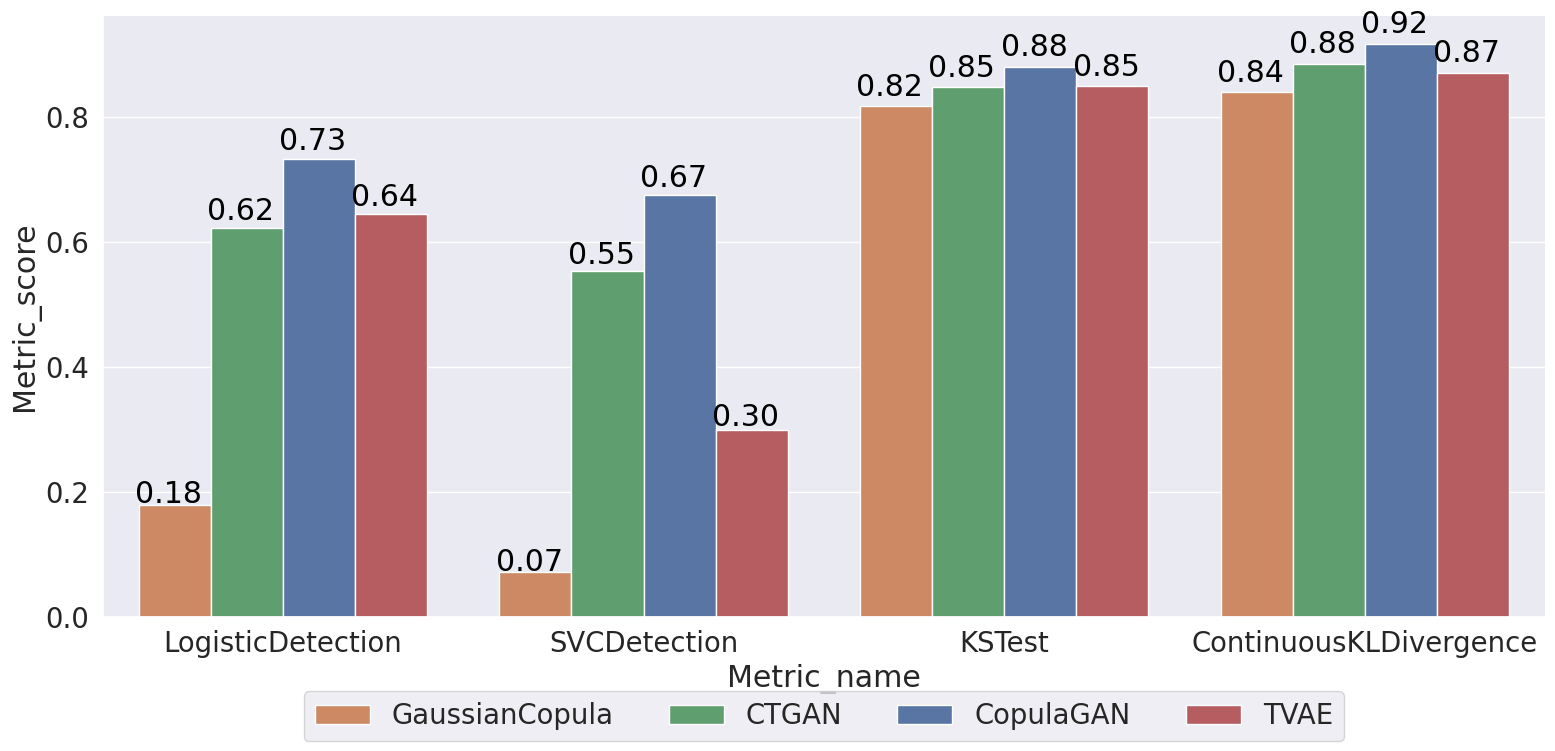

In [38]:
def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values

rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_pca, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_pca)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

Видно, что CopulaGAN дает вполне приличное качество по всем метрикам.

# Response function Real component quality

Проверим, что использование эмбеддингов не ухудшает качество компоненты Real функции отклика.

# Logistic Regression

In [12]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + ITEMS_FEATURES,
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(pca_users, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

Fitting of logistic regression: 
162.77151155471802


In [13]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [14]:
test_df = log_df_test.join(pca_users_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [15]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.003083467483520508


In [16]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.7034078193581302


# Random forest

In [17]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
221.1154909133911


In [18]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [19]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.001392364501953125


In [20]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.654858320485635


Оказалось, что при использовании эмбеддингов PCA качество компоненты Real примерно такое же, что в случае исходных фич.

# Non-negative ALS

Проделаем те же самые эксперименты с другим методом генерации эмбеддингов.

In [35]:
log_df_train = log_df_train.withColumnRenamed('user_idx', 'user')
log_df_train = log_df_train.withColumnRenamed('item_idx', 'item')
log_df_train = log_df_train.withColumnRenamed('relevance', 'rating')

In [36]:
als = ALS(rank=15, maxIter=10, seed=0, nonnegative = True)
start = time.time()
model = als.fit(log_df_train.select(["user", "item", "rating"]))
end = time.time()
print("Fitting of ALS: ")
print(end - start)

Fitting of ALS: 
217.14171171188354


In [37]:
user_features = model.userFactors.orderBy("id")
user_features = (user_features.withColumn('user_feature', col('features'))).select(['id'] + [col('user_feature')[i] for i in range(15)])
user_features.toPandas()

,id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8],user_feature[9],user_feature[10],user_feature[11],user_feature[12],user_feature[13],user_feature[14]
0,2383,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2385,0.245534,0.172440,0.344327,0.200965,0.146040,0.327830,0.187076,0.275170,0.300525,0.269674,0.193302,0.245313,0.185434,0.171727,0.135572
2,2390,0.251908,0.207670,0.247288,0.282505,0.208803,0.078348,0.221029,0.291001,0.277436,0.171312,0.237023,0.275307,0.294408,0.278260,0.272838
3,2392,0.186774,0.257921,0.201331,0.246305,0.159625,0.176895,0.194542,0.220106,0.197501,0.360084,0.193724,0.170992,0.267877,0.421415,0.309787
4,2395,0.246700,0.208987,0.278949,0.202035,0.292729,0.274730,0.300689,0.261377,0.285108,0.258784,0.195615,0.210507,0.206208,0.176201,0.254942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463375,6643662,0.281950,0.000000,0.126189,0.369250,0.000000,0.312394,0.000000,0.409704,0.043337,0.135041,0.000000,0.000000,0.563691,0.230912,0.076006
2463376,6643663,0.250640,0.239879,0.192922,0.208241,0.054838,0.285122,0.154413,0.139436,0.181964,0.271455,0.141526,0.176288,0.285867,0.215032,0.287565
2463377,6643664,0.000000,0.206310,0.118919,0.000000,0.300441,0.581755,0.000000,0.000000,0.013241,0.156436,0.000000,0.258774,0.073263,0.554780,0.000000
2463378,6643666,0.000000,0.335162,0.081699,0.000000,0.561159,0.000000,0.000000,0.234718,0.125929,0.000000,0.445215,0.000000,0.132593,0.421750,0.011664


In [38]:
log_df_val = log_df_val.withColumnRenamed('user_idx', 'user')
log_df_val = log_df_val.withColumnRenamed('item_idx', 'item')
log_df_val = log_df_val.withColumnRenamed('relevance', 'rating')

In [39]:
start = time.time()
model_val = als.fit(log_df_val.select(["user", "item", "rating"]))
end = time.time()
print("Fitting of ALS: ")
print(end - start)
user_features_val = model_val.userFactors.orderBy("id")
user_features_val = (user_features_val.withColumn('user_feature', col('features'))).select(['id'] + [col('user_feature')[i] for i in range(15)])

Fitting of ALS: 
133.6954460144043


In [40]:
log_df_train = log_df_train.withColumnRenamed('user', 'user_idx')
log_df_train = log_df_train.withColumnRenamed('item', 'item_idx')
log_df_train = log_df_train.withColumnRenamed('rating', 'relevance')

log_df_val = log_df_val.withColumnRenamed('user', 'user_idx')
log_df_val = log_df_val.withColumnRenamed('item', 'item_idx')
log_df_val = log_df_val.withColumnRenamed('rating', 'relevance')

# Generators quality with ALS

# GaussianCopula

In [58]:
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_1.fit(user_features.drop('id').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of GaussianCopula on NMF embeddings: ")
print(end - start)

Fitting of GaussianCopula on NMF embeddings: 
6.25581955909729


In [59]:
real_users = user_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [60]:
gen_score

{'LogisticDetection': 0.6727182924515471,
 'SVCDetection': 0.049607051532405966,
 'KSTest': 0.7916596951294133,
 'ContinuousKLDivergence': 0.7743578382331898}

In [61]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.DataFrame()
gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.672718,LogisticDetection
1,GaussianCopula,0.049607,SVCDetection
2,GaussianCopula,0.791660,KSTest
3,GaussianCopula,0.774358,ContinuousKLDivergence


# CTGAN

In [62]:
generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_2.fit(user_features.drop('id').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of CTGAN on NMF embeddings: ")
print(end - start)

Fitting of CTGAN on NMF embeddings: 
6652.749155282974


In [63]:
real_users = user_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [64]:
gen_score

{'LogisticDetection': 0.6299084624889948,
 'SVCDetection': 0.2721343397638917,
 'KSTest': 0.8876131738906519,
 'ContinuousKLDivergence': 0.928989422128462}

In [65]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.672718,LogisticDetection
1,GaussianCopula,0.049607,SVCDetection
2,GaussianCopula,0.791660,KSTest
3,GaussianCopula,0.774358,ContinuousKLDivergence
0,CTGAN,0.629908,LogisticDetection
1,CTGAN,0.272134,SVCDetection
2,CTGAN,0.887613,KSTest
3,CTGAN,0.928989,ContinuousKLDivergence


# CopulaGAN

In [66]:
generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_3.fit(user_features.drop('id').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of CopulaGAN on non-negative ALS embeddings: ")
print(end - start)

Fitting of CopulaGAN on non-negative ALS embeddings: 
7050.286105632782


In [67]:
real_users = user_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [68]:
gen_score

{'LogisticDetection': 0.47315122149595534,
 'SVCDetection': 0.1717674190077375,
 'KSTest': 0.8528850313851325,
 'ContinuousKLDivergence': 0.8818845465920642}

In [69]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.672718,LogisticDetection
1,GaussianCopula,0.049607,SVCDetection
2,GaussianCopula,0.791660,KSTest
3,GaussianCopula,0.774358,ContinuousKLDivergence
0,CTGAN,0.629908,LogisticDetection
1,CTGAN,0.272134,SVCDetection
2,CTGAN,0.887613,KSTest
3,CTGAN,0.928989,ContinuousKLDivergence
0,CopulaGAN,0.473151,LogisticDetection
1,CopulaGAN,0.171767,SVCDetection


# TVAE

In [70]:
generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='tvae',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_4.fit(user_features.drop('id').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of TVAE on non-negative ALS embeddings: ")
print(end - start)

Fitting of TVAE on non-negative ALS embeddings: 
3171.737803220749


In [71]:
real_users = user_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('id')
)

In [72]:
gen_score

{'LogisticDetection': 0.6724847238513756,
 'SVCDetection': 0.10973090123239704,
 'KSTest': 0.8164847347326842,
 'ContinuousKLDivergence': 0.7971667636446195}

In [73]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_nmf = pd.concat([gen_result_df_nmf, gen_result])
gen_result_df_nmf

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.672718,LogisticDetection
1,GaussianCopula,0.049607,SVCDetection
2,GaussianCopula,0.791660,KSTest
3,GaussianCopula,0.774358,ContinuousKLDivergence
0,CTGAN,0.629908,LogisticDetection
1,CTGAN,0.272134,SVCDetection
2,CTGAN,0.887613,KSTest
3,CTGAN,0.928989,ContinuousKLDivergence
0,CopulaGAN,0.473151,LogisticDetection
1,CopulaGAN,0.171767,SVCDetection


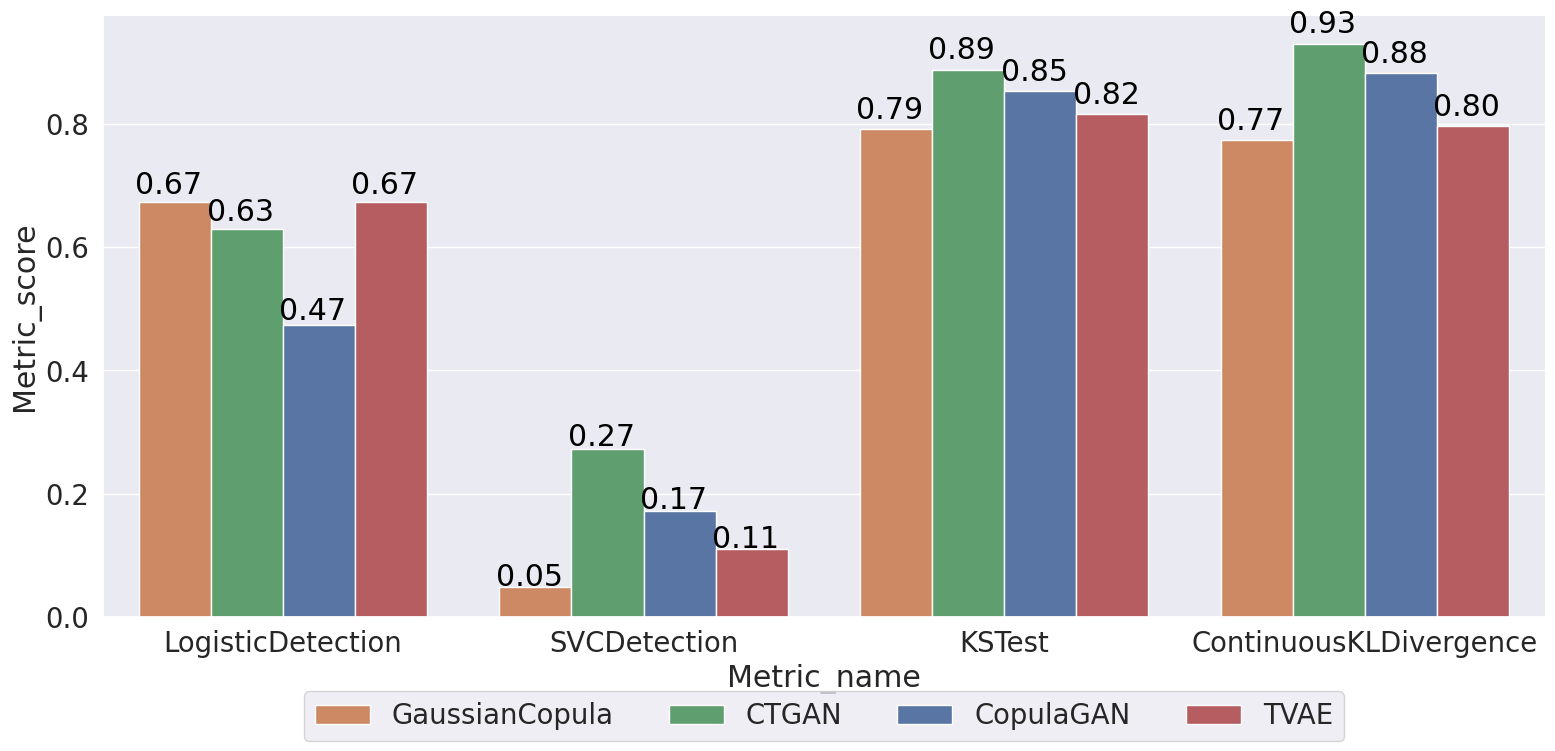

In [74]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_nmf, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_nmf)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

# Logistic Regression

In [41]:
user_features = user_features.withColumnRenamed('id', 'user_idx')

va = VectorAssembler(
    inputCols=user_features.columns[1:] + ITEMS_FEATURES,
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(user_features, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

Fitting of logistic regression: 
152.76289582252502


In [42]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [43]:
user_features_val = user_features_val.withColumnRenamed('id', 'user_idx')

test_df = log_df_test.join(user_features_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [44]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0014138221740722656


In [45]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.6971615915446185


# Random forest

In [46]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

Fitting of random forest: 
186.4813265800476


In [47]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [48]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0013964176177978516


In [49]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.6474054368489265


В случае метода ALS нет явно доминирующей по качеству модели генерации синтетики. Но качество компоненты Real все равно выше, чем в случае исходных профилей, для всех моделей аппроксимации отклика.

# Autoencoder

In [7]:
LATENT_DIM = 15

encoder = EncoderEstimator(
    inputCols=users_df_train.columns[1:],
    outputCols=[f'emb_{i}' for i in range(LATENT_DIM)],
    hidden_dim=16,
    lr=0.001,
    batch_size=64,
    num_loader_workers=4,
    max_iter=50,
    device_name='cpu'
)

start = time.time()
encoder_model = encoder.fit(users_df_train.sample(0.1))
end = time.time()
print("Fitting of aetoencoder: ")
print(end - start)
enc_features = encoder_model.transform(users_df_train)
enc_features.toPandas()

Fitting of aetoencoder: 
4831.841965913773


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14
0,-55.384621,-26.066240,23.602779,12.890759,35.191856,-38.570072,4.376272,27.026125,-13.948597,-15.030750,23.267294,43.803852,-21.134106,-39.547306,-46.060371
1,-54.289749,-25.601341,22.953699,12.534408,34.544460,-37.623722,4.406793,26.299332,-13.708128,-14.836297,22.642275,42.942104,-20.769413,-38.785439,-45.145412
2,-56.165520,-26.429953,23.964571,13.070158,35.681751,-39.131130,4.422016,27.437536,-14.154895,-15.224020,23.619669,44.429665,-21.431757,-40.110004,-46.715702
3,-53.748413,-26.056036,20.574642,10.862814,34.778706,-34.892262,5.761095,23.809723,-14.359859,-15.878355,20.441793,42.739540,-21.372662,-38.760834,-44.804886
4,-62.251606,-29.532825,25.857595,13.924690,39.733356,-42.577969,5.367488,29.702234,-15.980300,-17.252796,25.562141,49.351486,-24.053757,-44.594120,-51.830814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3053588,-66.778244,-31.429991,28.578163,15.449790,42.398212,-46.544697,5.218088,32.743382,-16.925053,-18.034348,28.188618,52.898304,-25.533972,-47.729633,-55.595181
3053589,-55.865372,-26.448004,23.111605,12.690089,35.662903,-38.263741,4.858248,26.549429,-14.100836,-15.547040,22.899597,44.171246,-21.495609,-39.930374,-46.406925
3053590,-64.568413,-31.067625,25.647390,13.469892,41.534817,-42.803436,6.334009,29.600939,-17.155216,-18.540115,25.408554,51.373940,-25.456213,-46.499519,-53.883209
3053591,-50.483337,-23.804317,21.433691,11.671958,32.109905,-35.044739,4.038173,24.531748,-12.790056,-13.751715,21.089542,39.938778,-19.295156,-36.073071,-42.002960


In [8]:
enc_features = enc_features.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
users_df_train = users_df_train.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

enc_features = enc_features.join(users_df_train, on=["row_index"]).drop("row_index")
cols = (users_df_train.columns[1:])
enc_features = enc_features.drop(*cols)
users_df_train = users_df_train.drop('row_index')

In [9]:
enc_features_val = encoder_model.transform(users_df_val)
enc_features_val = enc_features_val.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))
users_df_val = users_df_val.withColumn('row_index', row_number().over(Window.orderBy(monotonically_increasing_id())))

enc_features_val = enc_features_val.join(users_df_val, on=["row_index"]).drop("row_index")
cols = (users_df_val.columns[1:])
enc_features_val = enc_features_val.drop(*cols)

users_df_val = users_df_val.drop('row_index')
enc_features_val.toPandas()

22/11/07 11:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:04:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,user_idx
0,-58.567501,-27.894478,24.212231,12.857199,37.434570,-39.823933,5.127541,27.808844,-15.286071,-16.299463,23.862219,46.512699,-22.742746,-42.040653,-48.851444,3835593
1,-19.699715,-9.095296,9.031565,5.169590,12.395428,-14.420494,1.104160,10.145743,-4.756710,-5.052138,8.628333,15.410688,-7.164499,-13.930762,-16.339659,5139399
2,-56.052830,-26.870382,22.260447,11.992452,36.040092,-37.329151,5.482648,25.675209,-14.570953,-16.112244,22.102604,44.450993,-21.951124,-40.250248,-46.643150,5140169
3,-83.445770,-40.441757,32.965523,16.583563,53.771877,-54.711872,8.349578,38.102032,-22.974838,-24.026886,32.555832,66.752449,-33.307114,-60.397739,-69.949371,4971574
4,-62.774277,-30.427187,24.416502,12.594440,40.537556,-40.959835,6.501297,28.229864,-17.023096,-18.312372,24.171915,50.058212,-24.999247,-45.349346,-52.472111,6464618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904850,-48.988960,-23.175135,20.841705,11.137828,31.173244,-33.911522,3.898366,23.836512,-12.664509,-13.321163,20.415144,38.850704,-18.805531,-35.087849,-40.863583,5881176
4904851,-23.490433,-10.868986,10.667874,6.053597,14.792820,-17.082979,1.393819,12.030607,-5.701083,-6.062965,10.264081,18.417280,-8.615094,-16.636791,-19.492374,3784723
4904852,-10.245093,-4.420647,5.690636,3.516591,6.213714,-8.603592,-0.101982,6.212100,-2.109897,-2.121334,5.232312,7.824577,-3.258887,-7.048341,-8.430534,334079
4904853,-3.217996,-1.067021,2.865878,2.021590,1.713203,-3.893046,-0.775375,2.934376,-0.292276,-0.131917,2.388185,2.231815,-0.494487,-1.998823,-2.579468,5091065


# GaussianCopula

In [9]:
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_1.fit(enc_features.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of GaussianCopula on autoencoder embeddings: ")
print(end - start)

22/10/29 17:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 17:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of GaussianCopula on autoencoder embeddings: 
44.25078344345093


In [10]:
real_users = enc_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/29 17:22:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 17:22:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 17:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 17:22:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [11]:
gen_score

{'LogisticDetection': 0.7941911534110764,
 'SVCDetection': 0.44240807906283763,
 'KSTest': 0.8387477195725828,
 'ContinuousKLDivergence': 0.783709186710954}

In [12]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.DataFrame()
gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.794191,LogisticDetection
1,GaussianCopula,0.442408,SVCDetection
2,GaussianCopula,0.838748,KSTest
3,GaussianCopula,0.783709,ContinuousKLDivergence


# CTGAN

In [13]:
generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_2.fit(enc_features.sample(USER_GENERATOR_FRAC).drop('user_idx'))
end = time.time()
print("Fitting of CTGAN on autoencoder embeddings: ")
print(end - start)

22/10/29 17:25:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 17:25:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of CTGAN on autoencoder embeddings: 
9446.064270734787


In [14]:
real_users = enc_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/29 20:03:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 20:03:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 20:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 20:04:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [15]:
gen_score

{'LogisticDetection': 0.2704212742063975,
 'SVCDetection': 0.053421013868735656,
 'KSTest': 0.9264198023754865,
 'ContinuousKLDivergence': 0.212964536944907}

In [16]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.794191,LogisticDetection
1,GaussianCopula,0.442408,SVCDetection
2,GaussianCopula,0.838748,KSTest
3,GaussianCopula,0.783709,ContinuousKLDivergence
0,CTGAN,0.270421,LogisticDetection
1,CTGAN,0.053421,SVCDetection
2,CTGAN,0.926420,KSTest
3,CTGAN,0.212965,ContinuousKLDivergence


# CopulaGAN

In [17]:
generator_3 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_3.fit(enc_features.sample(USER_GENERATOR_FRAC).drop('user_idx'))
end = time.time()
print("Fitting of CopulaGAN on autoencoder embeddings: ")
print(end - start)

22/10/29 20:05:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 20:05:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of CopulaGAN on autoencoder embeddings: 
9411.104389429092


In [18]:
real_users = enc_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/29 22:42:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 22:42:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 22:43:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 22:43:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [19]:
gen_score

{'LogisticDetection': 0.340656881103391,
 'SVCDetection': 0.037955358432662845,
 'KSTest': 0.9332807933536927,
 'ContinuousKLDivergence': 0.21630132962137294}

In [20]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.794191,LogisticDetection
1,GaussianCopula,0.442408,SVCDetection
2,GaussianCopula,0.838748,KSTest
3,GaussianCopula,0.783709,ContinuousKLDivergence
0,CTGAN,0.270421,LogisticDetection
1,CTGAN,0.053421,SVCDetection
2,CTGAN,0.926420,KSTest
3,CTGAN,0.212965,ContinuousKLDivergence
0,CopulaGAN,0.340657,LogisticDetection
1,CopulaGAN,0.037955,SVCDetection


# TVAE

In [21]:
generator_4 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='tvae',
    parallelization_level=4,
    seed=1234
)

start = time.time()
generator_4.fit(enc_features.drop('user_idx').sample(USER_GENERATOR_FRAC))
end = time.time()
print("Fitting of TVAE on autoencoder embeddings: ")
print(end - start)

22/10/29 22:44:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 22:44:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Fitting of TVAE on autoencoder embeddings: 
3646.0534279346466


In [22]:
real_users = enc_features.sample(USER_GENERATOR_FRAC)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_idx')
)

22/10/29 23:45:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 23:45:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 23:46:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/10/29 23:46:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [23]:
gen_score

{'LogisticDetection': 0.8064438418397505,
 'SVCDetection': 0.11270303317607333,
 'KSTest': 0.9681786181233029,
 'ContinuousKLDivergence': 0.27663749841650276}

In [24]:
gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df_enc = pd.concat([gen_result_df_enc, gen_result])
gen_result_df_enc

,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.794191,LogisticDetection
1,GaussianCopula,0.442408,SVCDetection
2,GaussianCopula,0.838748,KSTest
3,GaussianCopula,0.783709,ContinuousKLDivergence
0,CTGAN,0.270421,LogisticDetection
1,CTGAN,0.053421,SVCDetection
2,CTGAN,0.926420,KSTest
3,CTGAN,0.212965,ContinuousKLDivergence
0,CopulaGAN,0.340657,LogisticDetection
1,CopulaGAN,0.037955,SVCDetection


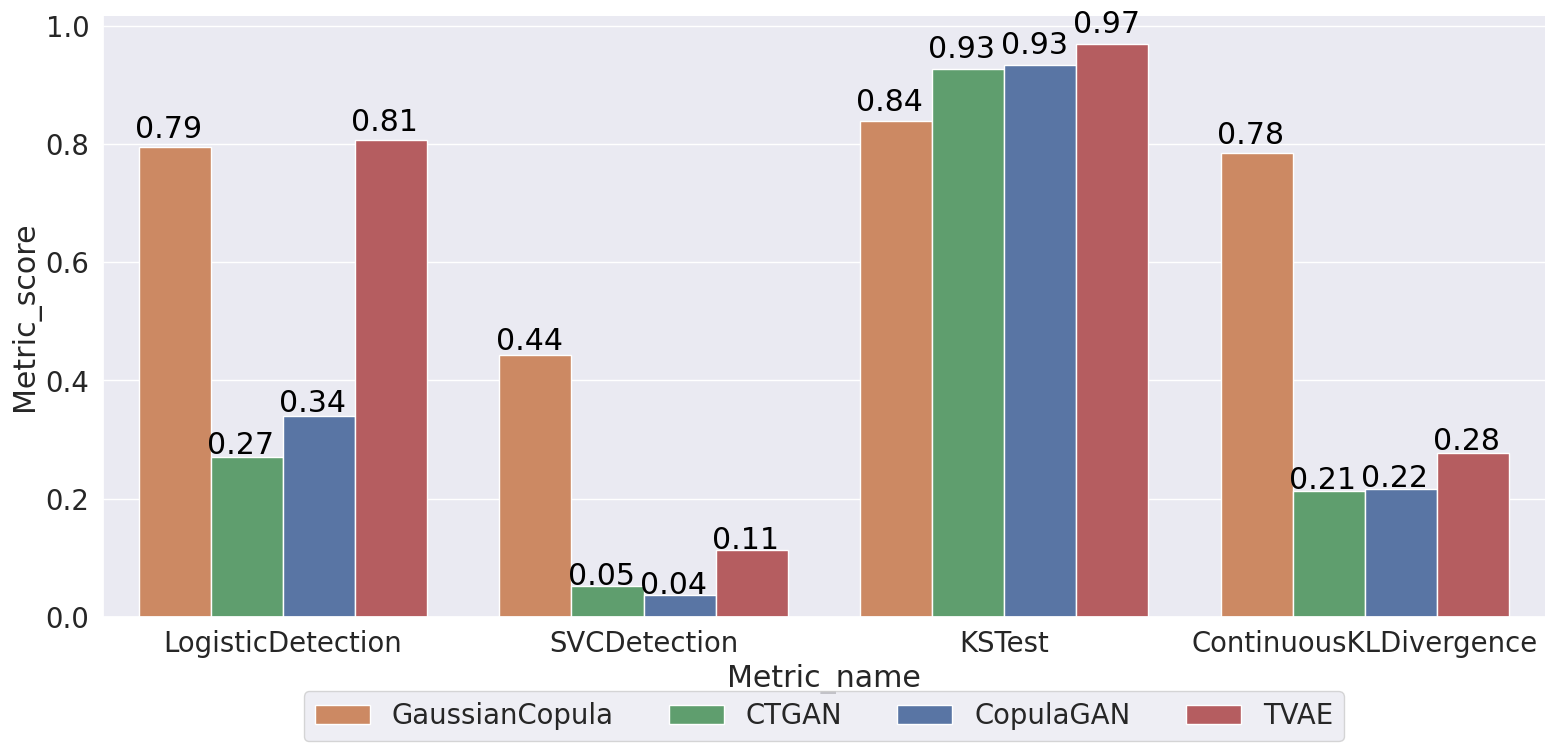

In [27]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8) 
plot = sns.catplot(data=gen_result_df_enc, x="Metric_name", y="Metric_score", hue="Model_name", kind="bar", aspect=2, height=8, palette=[
    "C1", "C2", "C0", "C3", "C4"
], legend=False)
ax = plot.facet_axis(0,0)
hist_val = create_hist_values(gen_result_df_enc)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

# Response function Real component quality

# Logistic Regression

In [10]:
va = VectorAssembler(
    inputCols=enc_features.columns[:-1] + ITEMS_FEATURES,
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

train_df = log_df_val.join(enc_features, 'user_idx', 'left')\
                     .join(items_df_train, 'item_idx', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

start = time.time()
lr_model = lr.fit(va.transform(train_df))
end = time.time()
print("Fitting of logistic regression: ")
print(end - start)

22/11/07 11:05:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:05:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:05:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:05:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:08:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/07 11:08:10 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/07 11:09:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cau

Fitting of logistic regression: 
193.35372161865234


22/11/07 11:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:09:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [11]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
br = BernoulliResponse (inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        lr_model,
        vee,
        br
    ]
)

In [12]:
test_df = log_df_test.join(enc_features_val, 'user_idx', 'left')\
                     .join(items_df_val, 'item_idx', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [13]:
start = time.time()
ber_lr_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_lr_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0043487548828125


22/11/07 11:09:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:09:05 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [14]:
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Regression ROC AUC: 0.6737337323365594


# Random forest

In [15]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

start = time.time()
rf_model = rf.fit(va.transform(train_df))
end = time.time()
print("Fitting of random forest: ")
print(end - start)

22/11/07 11:11:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:11:59 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:12:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:12:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:13:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:13:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 1

Fitting of random forest: 
278.3545169830322


22/11/07 11:16:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:16:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [16]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
br = BernoulliResponse(inputCol='__r1', outputCol='response', seed=1234)
pipeline = Pipeline(
    stages=[
        va,
        rf_model,
        vee,
        br
    ]
)

In [17]:
start = time.time()
ber_rf_model = pipeline.fit(train_df)
end = time.time()
print("Pipeline fitting: ")
print(end - start)
pred_df = ber_rf_model.transform(test_df).select("user_idx", "item_idx", "relevance", "__r1").toPandas()

Pipeline fitting: 
0.0009441375732421875


22/11/07 11:16:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/11/07 11:16:39 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [18]:
print(f"Random forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")

Random forest ROC AUC: 0.5961702447710591


Качество моделей генерации синтетики в случае эмбеддингов на основе автоэнкодера хуже чем в случае PCA. Качество компоненты Real на эмбеддингах сопоставимо с качеством компоненты Real на исходных профилях для всех моделей отклика.

По результатам экспериментального исследования было принято решение об использовании эмбеддингов профилей пользователей на основе PCA и модели CopulaGAN в случае датасета Amazon.